# <font color='red'> Project-1-Part2 </font> 
# <font color='blue'> Prediction of  House Price in King County with Regression Model</font> 

In Part 1 we have finished the exploratory data analysis. The following step is to analyze houses prices for King County, Washington by applying regression models to explore the correlation between the sale price and other variables in the dataset. I am going to apply data normalization between varialbes and conduct feature engineering. Then, I will be applying different machine learning algorithms and evaluating their respective success to a splitted train-test set. GridSearchCV is used for hyperparameters tuning. It includes two sections in the Part 2:  

1. Feature Engineering

2. Modeling


## <font color='red'> 1.Feature Engineering</font> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('kc_house_data.csv', parse_dates=['date']) 

In [3]:
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Standardise Variable to Identify Key Feature(s)

### Initial observations and recommendations

- `Price` 
    - <font color ="red">target label</font>
    - Given from the histogram, the sale price has appreciable positive skewness,deviates from the normal distribution and shows peakedness. 
    - <font color ="red">This is quite significant. At the data standardisation section, we will fix this. </font>

- `id`, `date`
    - <font color ="blue">delete, for now</font>
- `: Floors, view, condition and grade. zipcode` 
    - looking as categorical data 
    - No nulls
    - having a large number in zipcode column.
    - <font color ="red">using pd.get_dummies() method for encoding</font>
- `bedrooms, bathrooms, sqft_living, sqft_lot, sqft_above, sqft_living15, sqft_lot15`
    - No nulls, numeric data
    - analyzing bathrooms and bedrooms as continuous.
    - skewness and needing normalization.
    - <font color ="red">using log() to transform</font>
- `sqft_basement`, `yr_renovated`
    - Transforming these two columns by assuming as such:
            `lambda x: 1 if x > 0 else 0`
    - <font color ="red">Need to transform<font>
- `yr_built`, `waterfront`
    - No nulls
    - After transformation of price it appears to have a linear relationship.
    - <font color ="blue">Keep</font>
- `lat` and `long`
    - No nulls
    - This appears to be very clean
    - <font color ="blue">Keep</font>

    

In [4]:
df_raw.drop(['id', 'date'], axis=1, inplace=True)

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [6]:
df_raw['log_price'] = np.log1p(df_raw['price'])
df_raw['log_bedrooms'] = np.log1p(df_raw['bedrooms'])
df_raw['log_bathrooms'] = np.log1p(df_raw['bathrooms'])
df_raw['log_sqft_living'] = np.log1p(df_raw['sqft_living'])
df_raw['log_sqft_lot'] = np.log1p(df_raw['sqft_lot'])
df_raw['log_sqft_above'] = np.log1p(df_raw['sqft_above'])
df_raw['log_sqft_living15'] = np.log1p(df_raw['sqft_living15'])
df_raw['log_sqft_lot15'] = np.log1p(df_raw['sqft_lot15'])

  
categorical data: Floors, view, condition and grade.  


In [7]:
# indicate whether there is a basement.
df_raw['basement'] = df_raw['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
# 1 means the house has been renovated.
df_raw['renovated'] = df_raw['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
categorical_cols = ['floors', 'view', 'condition', 'grade', 'zipcode']
for cc in categorical_cols:
    dummies = pd.get_dummies(df_raw[cc], drop_first=False)
    dummies = dummies.add_prefix('{}#'.format(cc))
    df_raw.drop(cc, axis=1, inplace=True)
    df_raw = df_raw.join(dummies)

In [9]:
df_raw.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,log_price,log_bedrooms,log_bathrooms,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15,basement,renovated,floors#1.0,...,zipcode#98107,zipcode#98108,zipcode#98109,zipcode#98112,zipcode#98115,zipcode#98116,zipcode#98117,zipcode#98118,zipcode#98119,zipcode#98122,zipcode#98125,zipcode#98126,zipcode#98133,zipcode#98136,zipcode#98144,zipcode#98146,zipcode#98148,zipcode#98155,zipcode#98166,zipcode#98168,zipcode#98177,zipcode#98178,zipcode#98188,zipcode#98198,zipcode#98199
0,221900.0,3,1.00,1180,5650,0,1180,0,1955,0,47.5112,-122.257,1340,5650,12.309987,1.386294,0.693147,7.074117,8.639588,7.074117,7.201171,8.639588,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,0,2170,400,1951,1991,47.7210,-122.319,1690,7639,13.195616,1.386294,1.178655,7.852050,8.887791,7.682943,7.433075,8.941153,1,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,0,770,0,1933,0,47.7379,-122.233,2720,8062,12.100718,1.098612,0.693147,6.647688,9.210440,6.647688,7.908755,8.995041,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,0,1050,910,1965,0,47.5208,-122.393,1360,5000,13.311331,1.609438,1.386294,7.581210,8.517393,6.957497,7.215975,8.517393,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,0,1680,0,1987,0,47.6168,-122.045,1800,7503,13.142168,1.386294,1.098612,7.427144,8.997271,7.427144,7.496097,8.923191,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Columns: 122 entries, price to zipcode#98199
dtypes: float64(12), int64(12), uint8(98)
memory usage: 6.0 MB


In [11]:
df_raw.columns.to_list()

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'log_price',
 'log_bedrooms',
 'log_bathrooms',
 'log_sqft_living',
 'log_sqft_lot',
 'log_sqft_above',
 'log_sqft_living15',
 'log_sqft_lot15',
 'basement',
 'renovated',
 'floors#1.0',
 'floors#1.5',
 'floors#2.0',
 'floors#2.5',
 'floors#3.0',
 'floors#3.5',
 'view#0',
 'view#1',
 'view#2',
 'view#3',
 'view#4',
 'condition#1',
 'condition#2',
 'condition#3',
 'condition#4',
 'condition#5',
 'grade#1',
 'grade#3',
 'grade#4',
 'grade#5',
 'grade#6',
 'grade#7',
 'grade#8',
 'grade#9',
 'grade#10',
 'grade#11',
 'grade#12',
 'grade#13',
 'zipcode#98001',
 'zipcode#98002',
 'zipcode#98003',
 'zipcode#98004',
 'zipcode#98005',
 'zipcode#98006',
 'zipcode#98007',
 'zipcode#98008',
 'zipcode#98010',
 'zipcode#98011',
 'zipcode#98014',
 'zipcode#98019',
 'zipcode#98022',
 'zipcode#98023',
 'zipcod

# <font color='red'> 2. Modeling</font>

In [12]:
#model selection and evaluation
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score


# Model libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [14]:
y = df_raw['log_price']

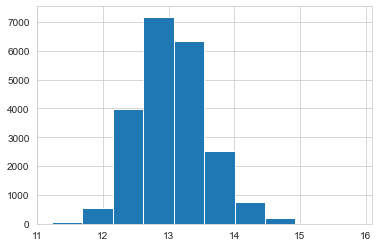

In [15]:
y.hist();

In [16]:
y.shape

(21613,)

In [17]:
X = df_raw.drop(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above','sqft_living15', 'sqft_lot15', 'sqft_lot', 'sqft_basement','yr_renovated','log_price'], axis = 1)

In [18]:
df_raw.shape

(21613, 122)

In [19]:
X.shape

(21613, 111)

In [20]:
X.head()

,waterfront,yr_built,lat,long,log_bedrooms,log_bathrooms,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_living15,log_sqft_lot15,basement,renovated,floors#1.0,floors#1.5,floors#2.0,floors#2.5,floors#3.0,floors#3.5,view#0,view#1,view#2,view#3,view#4,condition#1,...,zipcode#98107,zipcode#98108,zipcode#98109,zipcode#98112,zipcode#98115,zipcode#98116,zipcode#98117,zipcode#98118,zipcode#98119,zipcode#98122,zipcode#98125,zipcode#98126,zipcode#98133,zipcode#98136,zipcode#98144,zipcode#98146,zipcode#98148,zipcode#98155,zipcode#98166,zipcode#98168,zipcode#98177,zipcode#98178,zipcode#98188,zipcode#98198,zipcode#98199
0,0,1955,47.5112,-122.257,1.386294,0.693147,7.074117,8.639588,7.074117,7.201171,8.639588,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1951,47.7210,-122.319,1.386294,1.178655,7.852050,8.887791,7.682943,7.433075,8.941153,1,1,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1933,47.7379,-122.233,1.098612,0.693147,6.647688,9.210440,6.647688,7.908755,8.995041,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1965,47.5208,-122.393,1.609438,1.386294,7.581210,8.517393,6.957497,7.215975,8.517393,1,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1987,47.6168,-122.045,1.386294,1.098612,7.427144,8.997271,7.427144,7.496097,8.923191,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
pd.isnull(X).sum() > 0

waterfront           False
yr_built             False
lat                  False
long                 False
log_bedrooms         False
log_bathrooms        False
log_sqft_living      False
log_sqft_lot         False
log_sqft_above       False
log_sqft_living15    False
log_sqft_lot15       False
basement             False
renovated            False
floors#1.0           False
floors#1.5           False
floors#2.0           False
floors#2.5           False
floors#3.0           False
floors#3.5           False
view#0               False
view#1               False
view#2               False
view#3               False
view#4               False
condition#1          False
condition#2          False
condition#3          False
condition#4          False
condition#5          False
grade#1              False
grade#3              False
grade#4              False
grade#5              False
grade#6              False
grade#7              False
grade#8              False
grade#9              False
g

In [22]:
np.any(np.isnan(X))

False

In [23]:
np.all(np.isfinite(X))

True

In [24]:
np.any(np.isnan(y))

False

In [25]:
np.all(np.isfinite(y))

True

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [27]:
print("X Train Shape", X_train.shape)
print("Y Train Shape", y_train.shape)
print("X Test Shape", X_test.shape)
print("Y Test Shape", y_test.shape)

X Train Shape (17290, 111)
Y Train Shape (17290,)
X Test Shape (4323, 111)
Y Test Shape (4323,)


### Multiple Linear Regression  

Multiple Linear regression is a basic and commonly used type of predictive analysis.
* Have **Multiple features** and one target variable.
* The goal of multiple regression is to **model the linear relationship between your independent variables and your dependent variable**.

Assumptions of linear regression  
1. Linear relationship
2. Multivariate normality
3. No or little multi-collinearity
4. No auto-correlation
5. Homoscedasticity

In [28]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Score:', r2_score(y_pred, y_test))

Score: 0.8757880034116547


###  Ridge Regression
* Using L2 Regulazition

In [29]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train,y_train)
ridge_model_predict = ridge_model.predict(X_test)
print("Score: ",r2_score(ridge_model_predict,y_test))

Score:  0.8753555239721792


### Decision Tree Regression  
* Decision Trees are divided into Classification and Regression Trees.
* Regression trees are needed when the target variable is numeric or continuous. 
* Classification trees, as the name implies are used to separate the dataset into classes belonging to the target variable. 

In [30]:
SEED =1

In [31]:
tree_reg = DecisionTreeRegressor(random_state=SEED)
tree_reg.fit(X_train,y_train)
tree_reg_predict = tree_reg.predict(X_test)
print("Score: ",r2_score(tree_reg_predict,y_test))

Score:  0.7561609734823235


**hyperperameters tunning for decision tree regression**

In [32]:
# Define the grid of hyperparameters 'params_dt'
params_dt = {
'max_depth': [3, 4, 5, 6],
'max_features': [0.2, 0.4,0.6, 0.8],
'min_samples_leaf': [0.04, 0.06, 0.08]
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=tree_reg, 
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='r2')

In [33]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 0.04}


In [34]:
# Define the grid of hyperparameters 'params_dt' again
params_dt = {
'max_depth': [10, 12, 14, 16],
'max_features': [0.6, 0.8, 1.0],
'min_samples_leaf': [0.0006, 0.0008, 0.001, 0.002]

}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=tree_reg, 
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14, 16],
                         'max_features': [0.6, 0.8, 1.0],
                         'min_samples_leaf': [0.0006, 0.0008, 0.001, 0.002]},
             scoring='r2')

In [36]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 0.0008}


In [37]:
tree_reg = DecisionTreeRegressor(max_depth = 12,
                                 max_features = 1.0, 
                                 min_samples_leaf = 0.0008,
                                 random_state=SEED)
tree_reg.fit(X_train,y_train)
tree_reg_predict = tree_reg.predict(X_test)
print("Score: ",r2_score(tree_reg_predict,y_test))

Score:  0.8085282791892024


### Support Vector Regression
* Support Vector regression is a type of Support vector machine that supports linear and non-linear regression.
* In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold.
*It is to fit as many instances as possible between the lines while limiting the margin violations.The violation represents as ε (epsilon).

In [38]:
svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003)
svr.fit(X_train,y_train)
svr_predict = svr.predict(X_test)
print("Score: ",r2_score(svr_predict,y_test))

Score:  0.8603348021653001


### Random Forest Regression
* Bagging-based algorithm where only a subset of features are selected at random to build a forest or collection of decision trees.

In [39]:
rf = RandomForestRegressor(n_estimators=100, random_state = 42)
rf.fit(X_train,y_train)
rf_predict = rf.predict(X_test)
print("Score: ",r2_score(rf_predict,y_test))

Score:  0.8700344029435253


### Gradient Boosting
* Gradient Boosting employs gradient descent algortihm to minimize errors in sequential models.

In [40]:
reg_gb = GradientBoostingRegressor()
reg_gb.fit(X_train,y_train)
reg_gb_predict = reg_gb.predict(X_test)
print("Score: ",r2_score(reg_gb_predict,y_test))

Score:  0.8492527878687235


In [41]:
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42) 
gbr.fit(X_train,y_train)
gbr_predict = gbr.predict(X_test)
print("Score: ",r2_score(gbr_predict,y_test))

Score:  0.9017992929287926


### XGboost Regression
 XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.
* In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.

In [42]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgboost.fit(X_train,y_train)
xgboost_predict = xgboost.predict(X_test)
print("Score: ",r2_score(xgboost_predict,y_test))

Score:  0.9002329054738116


# Conclusion 
Various models were studied for their predictive power on the King County Housing data set. Linear models were found to be highly influenced by feature engineering. Nomalization of variables, especially for target variable(Price) are vital for prediction accuracy. Hyperparameter tuning with GridSearchCV is time cousuming and important to optimizing model performance. Highest R-square score (0.90) is achieved for gradient boosting regression and XGboost regression model with suitable parameters.